# Case Explanation

This project is a multiclass classification problem with the objective of developing model that can predict the severity of diabetic retinopathy on a scale of 0 to 4 from retina image. The images used for training and validation are from the folder "train_images", with the target variables taken from the file "train.csv". Moreover, the images used for testing are from the folder "test_images".

# Data Preprocessing

## Data Merging

The images' location paths used for training and validation are merged into the training dataframe.

In [1]:
# import libraries
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image

In [2]:
# size the column width when displayed
pd.options.display.max_colwidth = 100

# preview the file "train.csv"
df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [3]:
# insert a column for images' location path
df['path'] = df['id_code'].map(lambda x: os.path.join('/kaggle/input/aptos2019-blindness-detection/train_images', f'{x}.png'))
print(len(df))

# df is sorted alphanumerically to match with train_ds below
df = df.sort_values('path')
df

3662


,id_code,diagnosis,path
0,000c1434d8d7,2,/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png
1,001639a390f0,4,/kaggle/input/aptos2019-blindness-detection/train_images/001639a390f0.png
2,0024cdab0c1e,1,/kaggle/input/aptos2019-blindness-detection/train_images/0024cdab0c1e.png
3,002c21358ce6,0,/kaggle/input/aptos2019-blindness-detection/train_images/002c21358ce6.png
4,005b95c28852,0,/kaggle/input/aptos2019-blindness-detection/train_images/005b95c28852.png
...,...,...,...
3657,ffa47f6a7bf4,2,/kaggle/input/aptos2019-blindness-detection/train_images/ffa47f6a7bf4.png
3658,ffc04fed30e6,0,/kaggle/input/aptos2019-blindness-detection/train_images/ffc04fed30e6.png
3659,ffcf7b45f213,2,/kaggle/input/aptos2019-blindness-detection/train_images/ffcf7b45f213.png
3660,ffd97f8cd5aa,0,/kaggle/input/aptos2019-blindness-detection/train_images/ffd97f8cd5aa.png


## Data Visualization

Training data consist of retina images divided into 5 classes, with 0 as the most abundant and 3 as the least abundant.

<Axes: ylabel='diagnosis'>

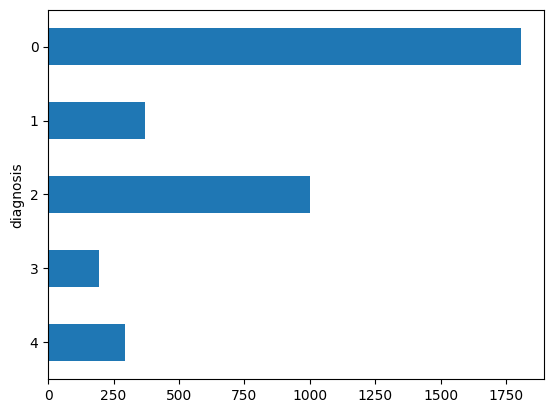

In [4]:
# visualize the data
df['diagnosis'].value_counts().sort_index(ascending = False).plot(kind = 'barh')

3216 2136


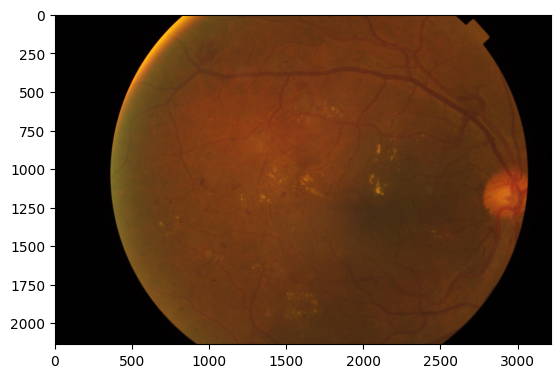

In [5]:
# display image
im = Image.open(df['path'].iloc[0])
width, height = im.size
print(width, height)
plt.imshow(im)

# Modeling

## Model Training

The model is convolutional neural networks with three convolution blocks and a max pooling layer in each of them. There's a fully-connected layer with 128 units on top of it that is activated by a ReLU activation function. Accuracy is used for evaluation metrics.

In [6]:
# set batch size and images' size
batch_size = 32
img_height = 180
img_width = 180

# build training data directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/aptos2019-blindness-detection/train_images',
    labels = df['diagnosis'].tolist(),
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    shuffle = 1000,
    image_size = (img_height, img_width),
    batch_size = batch_size)

# build validation data directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/aptos2019-blindness-detection/train_images',
    labels = df['diagnosis'].tolist(),
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    shuffle = 1000,
    image_size = (img_height, img_width),
    batch_size = batch_size)

# define variable class names
class_names = train_ds.class_names
print(class_names)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.
Found 3662 files belonging to 5 classes.
Using 732 files for validation.
['0', '1', '2', '3', '4']


In [7]:
# configure training & validation data for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [8]:
# construct model
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1/255), # rescale images from [0,225] (RGB range) to [0,1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [9]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# train model
epochs = 10
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10


I0000 00:00:1731638266.454493      81 service.cc:145] XLA service 0x78508001a1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731638266.454554      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731638266.454559      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 9/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3874 - loss: 1.4150

I0000 00:00:1731638270.096626      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 130s 330ms/step - accuracy: 0.6058 - loss: 1.0308 - val_accuracy: 0.7363 - val_loss: 0.7467
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7019 - loss: 0.7575 - val_accuracy: 0.7418 - val_loss: 0.7052
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7357 - loss: 0.7306 - val_accuracy: 0.7678 - val_loss: 0.6975
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7336 - loss: 0.7281 - val_accuracy: 0.7541 - val_loss: 0.6877
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7540 - loss: 0.6724 - val_accuracy: 0.7432 - val_loss: 0.7019
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7585 - loss: 0.6497 - val_accuracy: 0.7459 - val_loss: 0.7141
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7704 - loss: 0.5962 - val_accuracy: 0.7555 - val_loss: 0.7138
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7850 - loss: 0.5713 - val_accuracy: 0.7391 - val_loss:

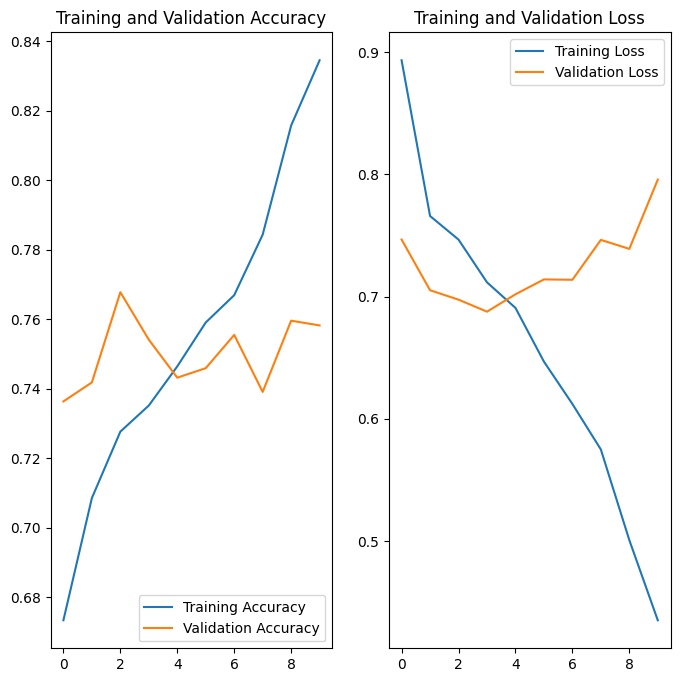

In [12]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Optimization

In the graph above, the training accuracy is increasing over time while the validation accuracy is relatively constant. This indicates overfitting, hence several modifications are done:
1. Data augmentation: adding more data by flipping, rotating, and zooming the original dataset
2. Converting the images into grayscale and increasing contrast
3. Increasing epochs 

In [13]:
# preprocess data
def preprocessing(img):
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.adjust_contrast(img, 1.5)
    return img

data_preprocessing = keras.Sequential(
  [
    layers.Lambda(preprocessing), # convert to grayscale and increase contrast
    layers.RandomFlip("horizontal"), # add more data by flipping
    layers.RandomRotation(0.1), # add more data by rotating
    layers.RandomZoom(0.1) # add more data by zooming
  ]
)

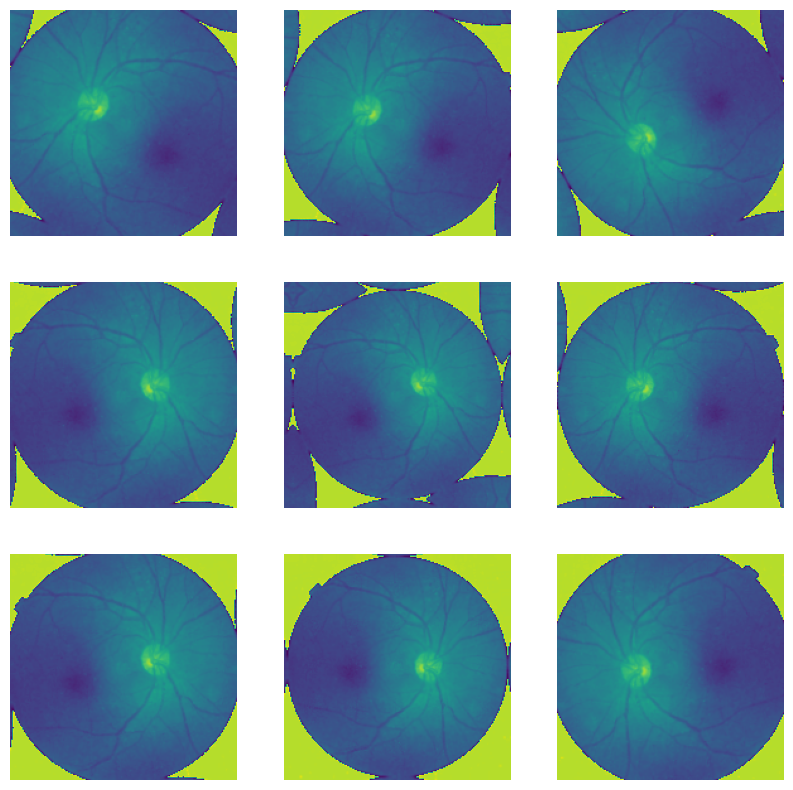

In [14]:
# visualize results
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_preprocessing(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
# construct model
model = Sequential([
  data_preprocessing,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [16]:
# compile model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [17]:
# model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# increase epochs; train model
epochs = 30 # after trial, the number of epochs is set to 30 so the validation loss is relatively decreasing over time
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/30


2024-11-15 02:38:37.880121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5178 - loss: 1.1997 - val_accuracy: 0.7008 - val_loss: 0.8566
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6462 - loss: 0.9606 - val_accuracy: 0.7240 - val_loss: 0.8866
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6796 - loss: 0.8820 - val_accuracy: 0.7199 - val_loss: 0.8104
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6919 - loss: 0.8432 - val_accuracy: 0.7213 - val_loss: 0.7886
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6786 - loss: 0.8492 - val_accuracy: 0.7322 - val_loss: 0.8212
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7081 - loss: 0.8085 - val_accuracy: 0.7473 - val_loss: 0.7843
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7168 - loss: 0.8141 - val_accuracy: 0.7527 - val_loss: 0.7873
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7072 - loss: 0.8074 - val_accuracy: 0.7377 - val_loss: 0.

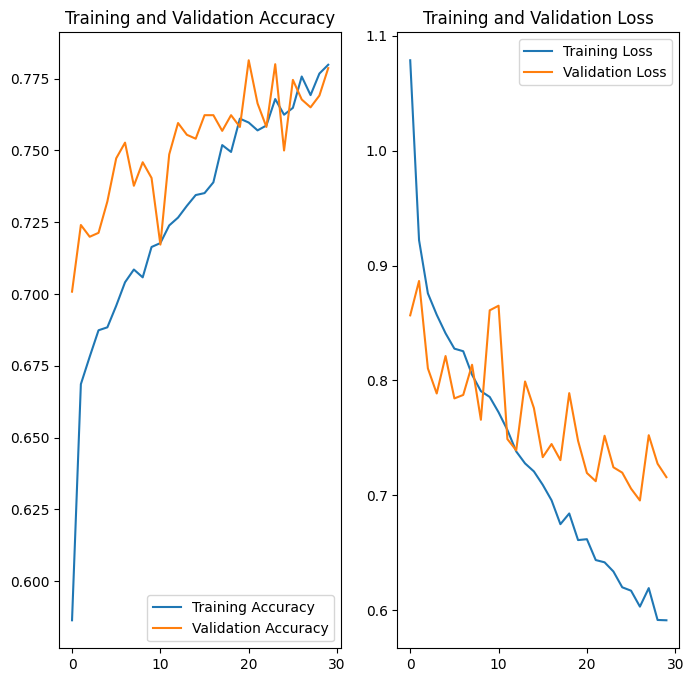

In [19]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Testing

The model is used to predict the target using testing data.

In [20]:
# preview the file "test.csv"
df_test = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
df_test

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4
...,...
1923,ff2fd94448de
1924,ff4c945d9b17
1925,ff64897ac0d8
1926,ffa73465b705


In [21]:
# insert a column for images' location path
df_test['path'] = df_test['id_code'].map(lambda x: os.path.join('/kaggle/input/aptos2019-blindness-detection/test_images', f'{x}.png'))
print(len(df_test))

# df_test is sorted alphanumerically to match with test_ds below
df_test = df_test.sort_values('path')
df_test

1928


,id_code,path
0,0005cfc8afb6,/kaggle/input/aptos2019-blindness-detection/test_images/0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/aptos2019-blindness-detection/test_images/003f0afdcd15.png
2,006efc72b638,/kaggle/input/aptos2019-blindness-detection/test_images/006efc72b638.png
3,00836aaacf06,/kaggle/input/aptos2019-blindness-detection/test_images/00836aaacf06.png
4,009245722fa4,/kaggle/input/aptos2019-blindness-detection/test_images/009245722fa4.png
...,...,...
1923,ff2fd94448de,/kaggle/input/aptos2019-blindness-detection/test_images/ff2fd94448de.png
1924,ff4c945d9b17,/kaggle/input/aptos2019-blindness-detection/test_images/ff4c945d9b17.png
1925,ff64897ac0d8,/kaggle/input/aptos2019-blindness-detection/test_images/ff64897ac0d8.png
1926,ffa73465b705,/kaggle/input/aptos2019-blindness-detection/test_images/ffa73465b705.png


640 480


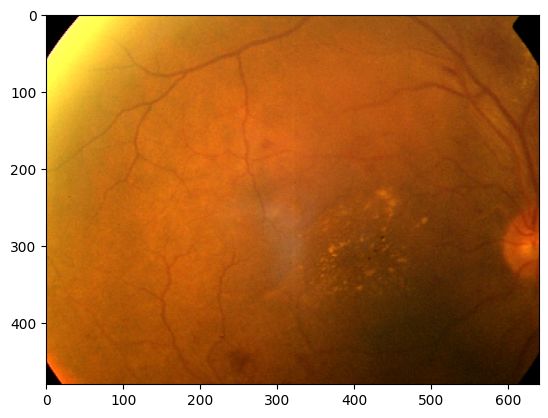

In [22]:
# display image to check whether it has been sorted correctly
im = Image.open(df_test['path'].iloc[0])
width, height = im.size
print(width, height)
plt.imshow(im)

In [23]:
# build training data directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/aptos2019-blindness-detection/test_images',
    labels = None,
    shuffle = False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1928 files.


In [24]:
# configure testing data for performance
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [25]:
# predict with testing data
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions)
predictions = np.argmax(score, axis = 1)

# print predictions
predictions

61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 358ms/step


array([2, 3, 2, ..., 2, 3, 0])

In [26]:
# merge the results with df_test
df_test['diagnosis'] = predictions
df_test = df_test.drop('path', axis = 1)
df_test

# save the result to csv
df_test.to_csv('submission.csv', index = False)